### First experiments with U-Net on real world slp data

Try U-Net following [Xiantao et al., 2020](https://www.nature.com/articles/s41598-020-59801-x), but with only 4 convolutions, opposed to 5.
Work with real world slp samples. Omit final row, to have number of rows evenly divideable by 2 for all three max pooling operations.

Choose **mask type**: Can either have random sparsity mask, individually for each data sample ('variable'), or create only a single random mask, that is then applied to all samples identically ('fixed'). 
And optionally extend data with **augmentation factor**: Specify the number of times, each sample is to be cloned, keeping the original order.

#### Experiments:

1) **mask_type='fixed', augmentation_factor=1:** Base experiment, according to szenario to have limitet number of measurements from stations, that are fixed in their location. Fast to train, low ressources required.
2) **mask_type='variable', augmentation_factor=1:** Extends base experiment, can handle variable inputs with fixed sparsity in single model. Fits to observations from e.g. argo floats on their trajectory or well suited for e.g. sea surface temperature measurements, where varying cloud coverage limits infrared observations. In its simples form, use each sample only once. Expect worse performance, commpared to base experiment.
3) **mask_type='variable', augmentation_factor>0:** Improve performance by using each input sample multiple times, allowed by random sparsity. Try to reduce overfitting and increase generalization on unseen data. Comes at the expense of increased training time.

Use **sparse and scaled (to [0,1]) samples as inputs**. Use **complete and scaled (to [0,1]) samples as targets**.

Got results on nesh, using GPU cluster node with batch **unet_4conv_slp_realworld.py**. Specify **mask_type** and **augmentation_factor**!

#### Results:

In general, get some nice results: Model predictions capture the main structure in slp anomalies, even for *sparsity=0.99*.

In terms of mean squarred error on training and validation data, models from our base experiment (experiment 1) trained on **fixed** sparsity mask **outperformes** models trained on **variable** mask, at least **without data augmentation** (experiment 2), as expected. But it's a trade off, since models from experiment 2 have higher flexibility: Can feed samples with specified sparsity but can freely choose, *which* inputs to use. The price is - as mentioned - a slightly worse reconstruction quality, which can be hardly recognized with human eye.

Adding data augmentation **factor=2** (experiment 3), model performance significantly improves and beats performance from our base experiment, keeping full flexibility in a sense, that we can freely choose input pixels, at least if we keep sparsity fixed.

**Note:** Need multi-run experiments for each setup, show error bars. And run experiment 3 with higher augmentation factors to validate the story.

#### Sensitivity check:

Now we have U-Net models that are trained to predict on samples with specified sparsity but allow to arbitrarily choose, *which* inputs we present. The next question then is: Can we use e.g. a model pretrained on sparsity=0.95 and feed samples with different , e.g. sparsity 0.99 and 0.9, respectively? How does validation loss change? 

That works quite nice: Especially for fixed sparsity=0.9, we find that model to almost perfectly perform in the sparsity range of [0.95, 0.75]. Our flexibility is hence further increased: Can not only freely choose, which inputs to use, but can also use a varying number of inputs, at least in a certain range!

**But note:** When we use the pre-trained model on sparsity=0.9 and use it on validation inputs with sparsity=0.95, we find even slightly lower validation loss, compared to using the *correct* model, pre-trained on sparsity=0.95. That appears to be un-intuitive and needs to be further investigated!

In [1]:
import os
import sys
sys.path.append('../src')
from pathlib import Path
from json import dump, load

import numpy as np
from matplotlib import pyplot as plt

from data import load_data, clone_data, create_sparsity_mask, split_and_scale_data
from models import build_unet_4conv

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate, Conv1D, Conv2D, MaxPool2D, UpSampling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model

# Suppress Tensorflow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
# Set working directory, according to working directory in scripts:
os.chdir('/gxfs_work1/geomar/smomw511')

In [3]:
# Specify experiments to compare:
model_config = 'unet_4conv'
source = 'slp_realworld'
mask_types = ['fixed','variable','variable','variable']
augmentation_factors = [1,1,2,3]

# Reconstruct path to experiment:
paths = []
for i in range(len(mask_types)):
    paths.append(Path('GitHub/MarcoLandtHayen/reconstruct-sparse-inputs/results/'+model_config+"_"+source+'_'+mask_types[i]+'_factor_'+str(augmentation_factors[i])))


In [4]:
paths

[PosixPath('GitHub/MarcoLandtHayen/reconstruct-sparse-inputs/results/unet_4conv_slp_realworld_fixed_factor_1'),
 PosixPath('GitHub/MarcoLandtHayen/reconstruct-sparse-inputs/results/unet_4conv_slp_realworld_variable_factor_1'),
 PosixPath('GitHub/MarcoLandtHayen/reconstruct-sparse-inputs/results/unet_4conv_slp_realworld_variable_factor_2'),
 PosixPath('GitHub/MarcoLandtHayen/reconstruct-sparse-inputs/results/unet_4conv_slp_realworld_variable_factor_3')]

In [8]:
# Initialize storage for parameters of all experiments:
parameters_all = []

# Reload parameters for all experiments:
for path in paths:
    
    # Open corresponding parameter file and store:
    with open(path / 'parameters.json', 'r') as f:
        parameters_all.append(load(f))

# Convert to numpy array:
parameters_all = np.array(parameters_all)

In [11]:
# Extract certain parameters from first experiment. Note: These parameters are identical for all experiments of interest, here.
train_val_split = parameters_all[0]['train_val_split']
sparsity_all = parameters_all[0]['sparsity_all']
scale_to = parameters_all[0]['scale_to']
epochs = parameters_all[0]['epochs']

In [14]:
## Get an overview of final train and validation loss, depending on sparsity, for all experiments.
## Note: Start with epoch 0, hence untrained model.

# Initialize storage for final train and validation loss. Dimension: (#experiments, #sparsities)
train_loss_final_all = np.zeros((len(paths),len(sparsity_all)))
val_loss_final_all = np.zeros((len(paths),len(sparsity_all)))

# Loop over experiments:
for i in range(len(paths)):
    
    # Get path for current experiment:
    path = paths[i]

    # Loop over array of desired sparsity:
    for j in range(len(sparsity_all)):

        # Get current sparsity:
        sparsity = sparsity_all[j]

        # Reload loss:
        train_loss = np.load(path / 'sparsity_' f'{int(sparsity*100)}'/ 'train_loss.npy')
        val_loss = np.load(path / 'sparsity_' f'{int(sparsity*100)}'/ 'val_loss.npy')

        # Store final train and validation loss:
        train_loss_final_all[i,j] = train_loss[-1]
        val_loss_final_all[i,j] = val_loss[-1]

In [15]:
train_loss_final_all

array([[0.00110469, 0.00047191, 0.00025347, 0.000147  , 0.00013828],
       [0.00143248, 0.00071971, 0.00030194, 0.00022949, 0.00016281],
       [0.00115768, 0.0002917 , 0.00013834, 0.00013096, 0.0001337 ],
       [0.00121648, 0.00054504, 0.0002759 , 0.0001335 , 0.0001047 ]])

In [16]:
val_loss_final_all

array([[0.00122182, 0.00057046, 0.00030278, 0.00018196, 0.00016444],
       [0.00154025, 0.00077689, 0.00032748, 0.00024405, 0.00017706],
       [0.00126238, 0.00033877, 0.00016365, 0.00014772, 0.00014683],
       [0.0013354 , 0.00060956, 0.00031769, 0.00015815, 0.00011599]])

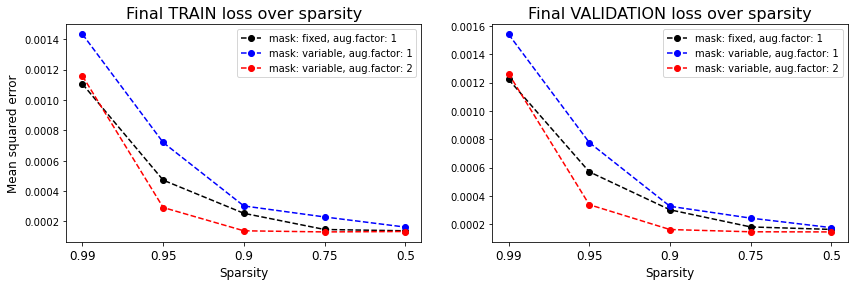

In [77]:
# Set colors for individual experiments:
colors = ['black', 'blue', 'red', 'green']

# Plot final train and validation loss over sparsity for all experiments:
fig, axes = plt.subplots(1,2,figsize=(14,4))

# Final train loss: Loop over experiments:
for i in range(3):
    axes[0].plot(
        train_loss_final_all[i,:], color=colors[i],
        label = 'mask: ' + parameters_all[i]['mask_type'] + ', aug.factor: ' + str(parameters_all[i]['augmentation_factor']),
        marker = 'o', linestyle = '--',
    )
    
# Final validation loss: Loop over experiments:
for i in range(3):
    axes[1].plot(
        val_loss_final_all[i,:], color=colors[i],
        label = 'mask: ' + parameters_all[i]['mask_type'] + ', aug.factor: ' + str(parameters_all[i]['augmentation_factor']),
        marker = 'o', linestyle = '--',
    )

# #plt.ylim(0.6, 0.8)
axes[0].set_xticks(np.arange(0, len(sparsity_all), step=1), sparsity_all, fontsize=12)
axes[1].set_xticks(np.arange(0, len(sparsity_all), step=1), sparsity_all, fontsize=12)
axes[0].set_title('Final TRAIN loss over sparsity', fontsize=16)
axes[1].set_title('Final VALIDATION loss over sparsity', fontsize=16)
axes[0].set_xlabel('Sparsity', fontsize=12)
axes[1].set_xlabel('Sparsity', fontsize=12)
axes[0].set_ylabel('Mean squared error', fontsize=12)
axes[0].legend()
axes[1].legend()
plt.show() 

### Sensitivity check

- Use pretrained model on fixed sparsity, allowing *flexible* mask, trained with *augmentation_factor=2*.
- Feed Validation inputs with *all* sparsities into selected model, pretrained on fixed sparsity.
- How does validation loss change?

In [98]:
# Specify experiment:
model_config = 'unet_4conv'
source = 'slp_realworld'
mask_type = 'variable'
augmentation_factor = 2

# Reconstruct path to experiment:
path = Path('GitHub/MarcoLandtHayen/reconstruct-sparse-inputs/results/'+model_config+"_"+source+'_'+mask_type+'_factor_'+str(augmentation_factor))

# Reload parameters for this experiment:
with open(path / 'parameters.json', 'r') as f:
    parameters=load(f)

train_val_split = parameters['train_val_split']
sparsity_all = parameters['sparsity_all']
scale_to = parameters['scale_to']
epochs = parameters['epochs']

In [99]:
# Load data, only to infer sample dimensions (lat,lon):
data = load_data(source=source)

# Get number of train and validation samples: Consider augmentation factor!
n_train = int(len(data) * augmentation_factor * train_val_split)
n_val = (len(data)*2) - n_train

In [100]:
## Sensitivity experiment for model, pretrained with fixed sparsity 0.95:
## Compare predictions and targets, for selected sparsity settings after final epoch.

# Selected sparsity settings:
sparsity_all_temp = [0.99, 0.95, 0.9, 0.75, 0.5]

# Fixed sparsity, to compare with, needed to re-load specific model:
sparsity_fix = 0.95

# Initialize storage for validation inputs: Dimensions (#sparsities, #val.samples, lat, lon)
val_input_all = np.zeros((len(sparsity_all_temp), n_val, data.shape[1], data.shape[2]))

# Initialize storage for validation targets: Dimensions (#val.samples, lat, lon)
val_target_all = np.zeros((n_val, data.shape[1], data.shape[2]))

# Initialize storage for validation predictions: Dimensions (#sparsities, #samples, lat, lon)
val_pred_all_sparsity_95 = np.zeros((len(sparsity_all_temp), n_val, data.shape[1], data.shape[2]))

# Reload specific pre-trained model after final epoch:
model = tf.keras.models.load_model(path / 'sparsity_' f'{int(sparsity_fix*100)}' / f'epoch_{epochs}')
        
# Loop over array of specified sparsities:
for i in range(len(sparsity_all_temp)):
        
    # Get current sparsity:
    sparsity = sparsity_all_temp[i]
    
    # Show status:
    print('Sparsity: ', i+1, ' of ', len(sparsity_all_temp))
    
    ## Load complete data, reconstruct sparse data and inputs and targets:

    # Load data:
    data = load_data(source=source)
    
    # Extend data:
    data = clone_data(data=data, augmentation_factor=augmentation_factor)

    # Reload sparsity mask:
    sparsity_mask = np.load(path / 'sparsity_' f'{int(sparsity*100)}' / 'sparsity_mask.npy')
    
    # Use sparse data as inputs and complete data as targets. Split sparse and complete data into training and validation sets. 
    # Scale or normlalize data according to statistics obtained from only training data.
    train_input, val_input, train_target, val_target, train_min, train_max, train_mean, train_std = split_and_scale_data(
        data, 
        sparsity_mask, 
        train_val_split, 
        scale_to
    )
    
    # Store inputs: Omit final dimension of predictions, that only contains the channel (here: 1)
    val_input_all[i,:,:,:] = val_input[:,:,:,0]
    
    # Store targets: Only once!
    val_target_all[:,:,:] = val_target[:,:,:]

    # Get model predictions on validation data:
    val_pred = model.predict(val_input)

    # Store predictions: Omit final dimension of predictions, that only contains the channel (here: 1)
    val_pred_all_sparsity_95[i,:,:,:] = val_pred[:,:,:,0]

Sparsity:  1  of  5
Sparsity:  2  of  5
Sparsity:  3  of  5
Sparsity:  4  of  5
Sparsity:  5  of  5


In [101]:
## Compute validation loss for sensitivity experiment with fixed sparsity 0.95:

# Initialize storage:
val_loss_final_sensitivity_sparsity_95 = []

# Loop over sparsities:
for i in range(len(sparsity_all_temp)):
    print('Sparsity: ', sparsity_all_temp[i], ', validation loss: ', np.round(np.mean((val_target_all - val_pred_all_sparsity_95[i])**2),6))
    
    # Store validation loss:
    val_loss_final_sensitivity_sparsity_95.append(np.mean((val_target_all - val_pred_all_sparsity_95[i])**2))

Sparsity:  0.99 , validation loss:  0.001802
Sparsity:  0.95 , validation loss:  0.000339
Sparsity:  0.9 , validation loss:  0.000298
Sparsity:  0.75 , validation loss:  0.001705
Sparsity:  0.5 , validation loss:  0.00695


In [102]:
# For comparison:
val_loss_final_all

array([[0.00122182, 0.00057046, 0.00030278, 0.00018196, 0.00016444],
       [0.00154025, 0.00077689, 0.00032748, 0.00024405, 0.00017706],
       [0.00126238, 0.00033877, 0.00016365, 0.00014772, 0.00014683],
       [0.0013354 , 0.00060956, 0.00031769, 0.00015815, 0.00011599]])

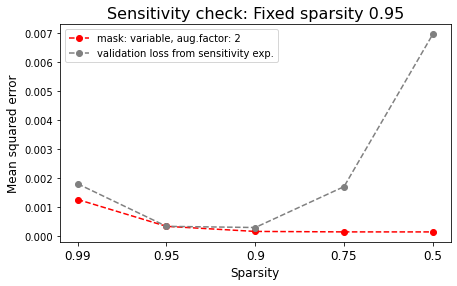

In [105]:
# Plot final train and validation loss over sparsity for sensitivity experiment with fixed sparsity 0.95:
fig, ax = plt.subplots(1,1,figsize=(7,4))

# Final validation loss, using 'correct' models:
ax.plot(val_loss_final_all[2,:], color=colors[2],
             label = 'mask: ' + parameters_all[2]['mask_type'] + ', aug.factor: ' + str(parameters_all[2]['augmentation_factor']),
             marker = 'o', linestyle = '--',
    )

# Final validation loss from sensitivity experiment:
ax.plot(val_loss_final_sensitivity_sparsity_95, color='grey',
             label = 'validation loss from sensitivity exp.',
             marker = 'o', linestyle = '--',
    )

ax.set_xticks(np.arange(0, len(sparsity_all), step=1), sparsity_all, fontsize=12)
ax.set_title('Sensitivity check: Fixed sparsity 0.95', fontsize=16)
ax.set_xlabel('Sparsity', fontsize=12)
ax.set_ylabel('Mean squared error', fontsize=12)
ax.legend()
plt.show() 

In [106]:
## Sensitivity experiment for model, pretrained with fixed sparsity 0.90:
## Compare predictions and targets, for selected sparsity settings after final epoch.

# Selected sparsity settings:
sparsity_all_temp = [0.99, 0.95, 0.9, 0.75, 0.5]

# Fixed sparsity, to compare with, needed to re-load specific model:
sparsity_fix = 0.9

# Initialize storage for validation inputs: Dimensions (#sparsities, #val.samples, lat, lon)
val_input_all = np.zeros((len(sparsity_all_temp), n_val, data.shape[1], data.shape[2]))

# Initialize storage for validation targets: Dimensions (#val.samples, lat, lon)
val_target_all = np.zeros((n_val, data.shape[1], data.shape[2]))

# Initialize storage for validation predictions: Dimensions (#sparsities, #samples, lat, lon)
val_pred_all_sparsity_90 = np.zeros((len(sparsity_all_temp), n_val, data.shape[1], data.shape[2]))

# Reload specific pre-trained model after final epoch:
model = tf.keras.models.load_model(path / 'sparsity_' f'{int(sparsity_fix*100)}' / f'epoch_{epochs}')
        
# Loop over array of specified sparsities:
for i in range(len(sparsity_all_temp)):
        
    # Get current sparsity:
    sparsity = sparsity_all_temp[i]
    
    # Show status:
    print('Sparsity: ', i+1, ' of ', len(sparsity_all_temp))
    
    ## Load complete data, reconstruct sparse data and inputs and targets:

    # Load data:
    data = load_data(source=source)
    
    # Extend data:
    data = clone_data(data=data, augmentation_factor=augmentation_factor)

    # Reload sparsity mask:
    sparsity_mask = np.load(path / 'sparsity_' f'{int(sparsity*100)}' / 'sparsity_mask.npy')
    
    # Use sparse data as inputs and complete data as targets. Split sparse and complete data into training and validation sets. 
    # Scale or normlalize data according to statistics obtained from only training data.
    train_input, val_input, train_target, val_target, train_min, train_max, train_mean, train_std = split_and_scale_data(
        data, 
        sparsity_mask, 
        train_val_split, 
        scale_to
    )
    
    # Store inputs: Omit final dimension of predictions, that only contains the channel (here: 1)
    val_input_all[i,:,:,:] = val_input[:,:,:,0]
    
    # Store targets: Only once!
    val_target_all[:,:,:] = val_target[:,:,:]

    # Get model predictions on validation data:
    val_pred = model.predict(val_input)

    # Store predictions: Omit final dimension of predictions, that only contains the channel (here: 1)
    val_pred_all_sparsity_90[i,:,:,:] = val_pred[:,:,:,0]

Sparsity:  1  of  5
Sparsity:  2  of  5
Sparsity:  3  of  5
Sparsity:  4  of  5
Sparsity:  5  of  5


In [109]:
## Compute validation loss for sensitivity experiment with fixed sparsity 0.90:

# Initialize storage:
val_loss_final_sensitivity_sparsity_90 = []

# Loop over sparsities:
for i in range(len(sparsity_all_temp)):
    print('Sparsity: ', sparsity_all_temp[i], ', validation loss: ', np.round(np.mean((val_target_all - val_pred_all_sparsity_90[i])**2),6))
    
    # Store validation loss:
    val_loss_final_sensitivity_sparsity_90.append(np.mean((val_target_all - val_pred_all_sparsity_90[i])**2))

Sparsity:  0.99 , validation loss:  0.00374
Sparsity:  0.95 , validation loss:  0.000328
Sparsity:  0.9 , validation loss:  0.000164
Sparsity:  0.75 , validation loss:  0.000197
Sparsity:  0.5 , validation loss:  0.000749


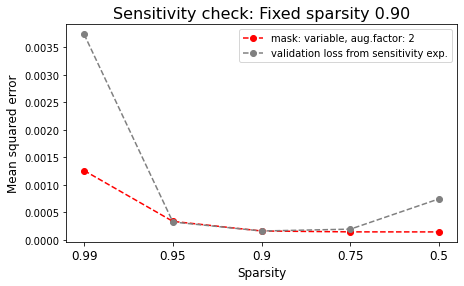

In [110]:
# Plot final train and validation loss over sparsity for sensitivity experiment with fixed sparsity 0.90:
fig, ax = plt.subplots(1,1,figsize=(7,4))

# Final validation loss, using 'correct' models:
ax.plot(val_loss_final_all[2,:], color=colors[2],
             label = 'mask: ' + parameters_all[2]['mask_type'] + ', aug.factor: ' + str(parameters_all[2]['augmentation_factor']),
             marker = 'o', linestyle = '--',
    )

# Final validation loss from sensitivity experiment:
ax.plot(val_loss_final_sensitivity_sparsity_90, color='grey',
             label = 'validation loss from sensitivity exp.',
             marker = 'o', linestyle = '--',
    )

ax.set_xticks(np.arange(0, len(sparsity_all), step=1), sparsity_all, fontsize=12)
ax.set_title('Sensitivity check: Fixed sparsity 0.90', fontsize=16)
ax.set_xlabel('Sparsity', fontsize=12)
ax.set_ylabel('Mean squared error', fontsize=12)
ax.legend()
plt.show() 

In [111]:
val_target_all.shape

(355, 72, 144)

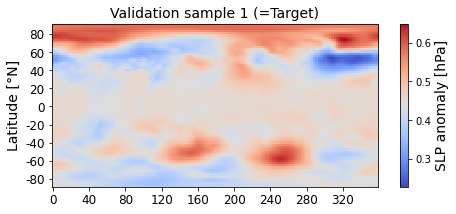

In [118]:
## Compare target to predictions:

# Pick sample number:
k=0

## Plot single validation target:
fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(val_target_all[k], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("SLP anomaly [hPa]", fontsize=14)

plt.title('Validation sample '+str(k+1)+' (=Target)', fontsize=14)
#plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

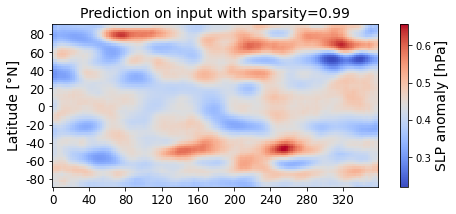

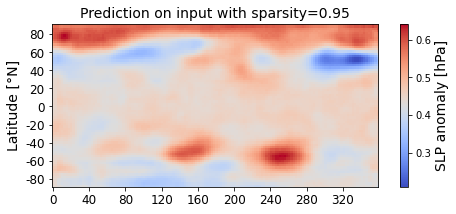

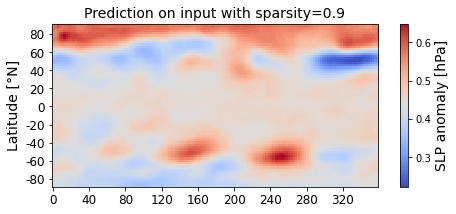

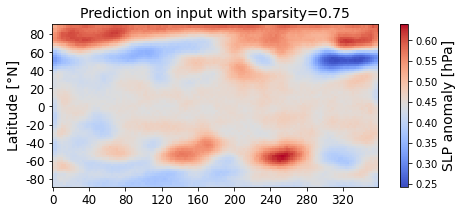

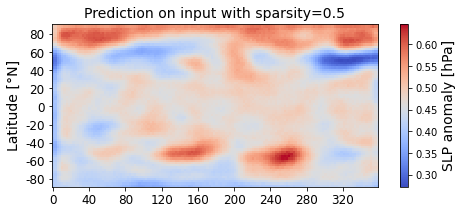

In [121]:
## Plot corresponding model prediction after final epoch:
## Use predictions from model, that is pre-trained on fixed sparsity=0.9, to infer from inputs with various sparsity.

# Loop over sparsities:
for i in range(len(sparsity_all_temp)):
    
    # Get current sparsity:
    sparsity=sparsity_all_temp[i]
    
    fig, ax = plt.subplots(figsize=(8, 3))

    im = plt.imshow(val_pred_all_sparsity_90[i,k,:,:], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label("SLP anomaly [hPa]", fontsize=14)

    plt.title('Prediction on input with sparsity='+str(sparsity), fontsize=14)
    if j == epochs:
        plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
    plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

    plt.show()